# Cavity propagation notebook

This notebook propagates a wavefront through a simple optical cavity.
The initial wavefront wfrCenter0 is a Hermite-Gaussian mode located at the center of a cavity
of length L_cav. There is a crystal located at the center of the cavity of length L_cryst. 
The wavefront is propagated through the crystal and then to the end of the cavity.

We continue by passing the wavefront through a thin lens with focal length Lc/4 + dfR. dfR$\neq0$ allows for a focusing error in the right mirror
mirror. It can be both positive and negative. The wavefront passes back through the cavity and crystal and then through the left lens with focal length Lc/4 + dfL. We now repeat N times.

We construct a list of all the wavefronts called cavitywfrList. These are propagated through the sections of the cavity. After the propagation, the wavefronts can be visualized at the three locations: center, right mirror, and left mirror.

A Sirepo/SRW simulation with comparable parameters is available at https://www.sirepo.com/srw#/beamline/MVQGzoQ2 however this simulation does not include the crystal.

The crystal is represented by an index of refraction that varies transversely with
n(r) = n0 - 0.5 n2 r^2 
This may be represented as an optical duct, or a GRIN media. We solve for the ABCD matrix and
then apply it via Linear Canonical Transform to propagate the wavefront.

In [1]:
#Import necessary libraries
from __future__ import print_function #Python 2.7 compatibility
#from srwlib import *
from silasOpticsLib import *
from srwl_uti_dataProcess import *
%load_ext autoreload
%autoreload 2
import numpy as np
import math
import os 
import sys
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.ndimage
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}

In [2]:
#Specify parameters for simulation
L_cav = 8 #Length of cavity [m]
df = 1 #Focal length difference from confocal case [m]
dfR = df
dfL = df
f=L_cav/4+df #focal length

#Crystal parameters
L_cryst = 4
#n0 = 1.76
#n2 = .01
n0=2
n2=0.02

wavefrontEnergy = 1.55 #Wavefront Energy [eV]. 1.55 eV is 800 nm wavelength
lam = 1239.8*1e-9/wavefrontEnergy # convert energy [eV] to wavelength [m]

L_eff = L_cav+(1/n0 - 1)*L_cryst #Define effective length as path length reduced by index of refraction n0
print("L_eff=",L_eff)
beta0 = np.sqrt(L_eff*f-L_eff**2/4)
print("beta0=",beta0)
sigx0 = np.sqrt(lam*beta0/4/np.pi)
print("sigx0=",sigx0)

#sigmaRCenter0 = 0.000424304 #Initial RMS beam size at center of cavity [m]
sigmaRCenter0 = sigx0

propLen=15 #Propagation of initial Gaussian [m]. It will then be back-propagated by propLen: a trick to get the Gaussian mode at the waist
pulseE = .001 #Total energy of pulse [eV]
mx = 0 #Horizontal mode number (0 for Gaussian)
my = 0 #Vertical mode number (0 for Gaussian)
poltype = 1 #Polarization of mode (0=linear horizontal, 1=linear vertical, 2=linear 45 deg, 3=linear 135 deg, 4=circular right, 5=circular left, 6=total)

sampFact = 5 #Determines grid size of initial wavefront


L_eff= 6.0
beta0= 3.0
sigx0= 0.00043698412731784714


In [3]:
#Now we construct the initial wavefront at the center of cavity
#wfr0=createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my)
wfrCenter0=createGsnSrcSRW(sigmaRCenter0,propLen,pulseE,poltype,wavefrontEnergy,sampFact,mx,my) #creates Gaussian wavefront in SRW
(nx0,ny0)=(wfrCenter0.mesh.nx,wfrCenter0.mesh.ny)
print("Initial wavefront calculated on a grid of %d x %d points" %(nx0,ny0))

Initial wavefront calculated on a grid of 216 x 216 points


In [4]:
#Now build the different beamline elements we need to propagate to the right and to the left
propagateHalfCrystal = createCrystal(n0,n2,L_cryst/2)
propagateRight = createDriftLensBL2((L_cav-L_cryst)/2,f)
propagateLeft = createDriftLensBL2((L_cav-L_cryst)/2,f)
propagateDrift = createDriftBL(L_cav-L_cryst)

In [5]:
#Now construct a list of wavefront objects starting with initial wavefront wfrCenter0

cavitywfrList = [wfrCenter0]
    
npass = 8    
#Now run through beamline and propagate wavefronts
start_time = time.time()
for i in range(npass):
    wfr = deepcopy(cavitywfrList[-1])
    srwl.PropagElecField(wfr, propagateHalfCrystal)
    cavitywfrList.append(wfr)
    wfr1 = deepcopy(wfr)
    srwl.PropagElecField(wfr1, propagateRight)
    cavitywfrList.append(wfr1)
    wfr2 = deepcopy(wfr1)
    srwl.PropagElecField(wfr2,propagateDrift)
    cavitywfrList.append(wfr2)
    wfr3 = deepcopy(wfr2)
    srwl.PropagElecField(wfr3,propagateHalfCrystal)
    cavitywfrList.append(wfr3)
    wfr4 = deepcopy(wfr3)
    srwl.PropagElecField(wfr4,propagateHalfCrystal)
    cavitywfrList.append(wfr4)
    wfr5 = deepcopy(wfr4)
    srwl.PropagElecField(wfr5, propagateLeft)
    cavitywfrList.append(wfr5)
    wfr6 = deepcopy(wfr5)
    srwl.PropagElecField(wfr6, propagateDrift)
    cavitywfrList.append(wfr6)
    wfr7 = deepcopy(wfr6)
    srwl.PropagElecField(wfr7, propagateHalfCrystal)
    cavitywfrList.append(wfr7)

print("Simulation time: %s seconds" %(round((time.time() - start_time),5)))


Simulation time: 0.60857 seconds


<function matplotlib.pyplot.show(*args, **kw)>

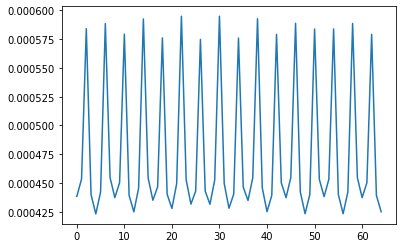

In [6]:
#Check the rms sizes along the way.
sxvals = []
syvals = []
for j in range(np.size(cavitywfrList)):
    (sx,sy) = rmsWavefrontIntensity(cavitywfrList[j])
    sxvals.append(sx)
    syvals.append(sy)
    #print(sx,sy)
    
fig, ax = plt.subplots()
ax.plot(sxvals)
plt.show

Size of initial wavefront data array (coordinate): (216, 216)


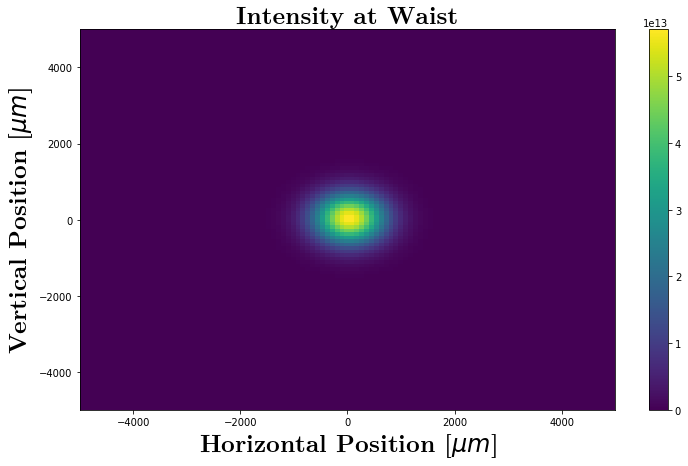

In [167]:
# Plot initial wavefront
##Initial wfr calculation
wavefrontToPlot = 15 #This can range from 0 to 3*npass
wfrplot = cavitywfrList[wavefrontToPlot] 

arIinit = array('f', [0]*wfrplot.mesh.nx*wfrplot.mesh.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfrplot, 6, 0, 3, wfrplot.mesh.eStart, 0, 0) #extracts intensity
##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfrplot.mesh.nx, wfrplot.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfrplot.mesh.xStart,wfrplot.mesh.xFin,wfrplot.mesh.nx)
yvalsf02=np.linspace(wfrplot.mesh.yStart,wfrplot.mesh.yFin,wfrplot.mesh.ny)

fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), arIinit2D, cmap=plt.cm.viridis)  ##By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
plt.colorbar()
#['Horizontal Position [mm]', , 'Intensity']
xmax = 5e3
ymax = 5e3
ax.set_ylim(-ymax,ymax)
ax.set_xlim(-xmax,xmax)
ax.set_ylabel(r'Vertical Position [$\mu m$]',**hfontLarge)
ax.set_xlabel(r'Horizontal Position [$\mu m$]',**hfontLarge)
ax.set_title('Intensity at Waist',**hfontLarge)
plt.show()